# 逻辑回归Sklearn实现

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

## 1. 逻辑回归中的L1正则化和稀疏性
通过对比使用不同的正则化参数得到的权重矩阵，来确定其稀疏性，也就是权重矩阵中值为0的权重数量。

In [4]:
# 加载sklearn中的手写数字数据集
digits = datasets.load_digits()
# 获取特征和类别标签
X, y = digits.data, digits.target
# 归一化参数
X = StandardScaler().fit_transform(X)
# 为了做二分类而不是多分类，将数字以4为分界点分为正反两个部分
y = (y > 4).astype(np.int)
X, y

(array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
          1.6951369 , -0.19600752],
        ...,
        [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
         -0.26113572, -0.19600752]]), array([0, 0, 0, ..., 1, 1, 1]))

C = 100.00
Sparsity with L1 penalty: 6.25%
score with L1 penalty: 0.9104
Sparsity with L2 penalty: 4.69%
score with L2 penalty: 0.9098


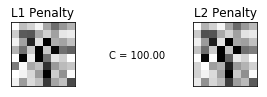

C = 1.00
Sparsity with L1 penalty: 9.38%
score with L1 penalty: 0.9104
Sparsity with L2 penalty: 4.69%
score with L2 penalty: 0.9093


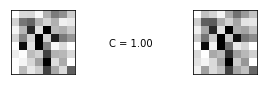

C = 0.01
Sparsity with L1 penalty: 85.94%
score with L1 penalty: 0.8625
Sparsity with L2 penalty: 4.69%
score with L2 penalty: 0.8915


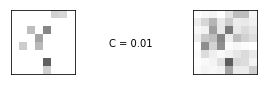

In [13]:
for i, C in enumerate((100, 1, 0.01)):
    # 设置正则化参数C（也就是1 / lambda)，tol为停止条件
    # C过大欠拟合，C过小过拟合
    clf_l1_LR = LogisticRegression(C = C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C = C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    
    # 得到l1正则和l2正则的系数向量
    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    
    # 解的稀疏度
    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    print("C = %.2f" % C)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X, y))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X, y))
    
    # 绘制不同正则化参数下的图像
    l1_plot = plt.subplot(3, 2, 2*i + 1)
    l2_plot = plt.subplot(3, 2, 2*(i + 1))
    if i == 0:
        l1_plot.set_title("L1 Penalty")
        l2_plot.set_title("L2 Penalty")
    # imshow绘制热图，这里显示非零的色块占比
    l1_plot.imshow(np.abs(coef_l1_LR.reshape(8, 8)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)
    l2_plot.imshow(np.abs(coef_l2_LR.reshape(8, 8)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)
    # text方法两个参数调整后面输出文字的位置，-11调整左右位置，4调整上下位置
    plt.text(-11, 4, "C = %.2f" % C)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    plt.show()

从上面输出结果可以看出，当C较小时，权重矩阵比较稀疏，也就是为0的项较多，模型欠拟合。相反，模型过拟合。

## 2. L1正则逻辑回归的路径

In [15]:
from datetime import datetime

from sklearn import linear_model
from sklearn.svm import l1_min_c

In [17]:
# 使用iris数据集
iris = datasets.load_iris()
X, y = iris.data, iris.target
X = X[y != 2]
y = y[y != 2]
X -= np.mean(X, 0)
X[:3], y[:3]

(array([[-0.371,  0.406, -1.462, -0.585],
        [-0.571, -0.094, -1.462, -0.585],
        [-0.771,  0.106, -1.562, -0.585]]), array([0, 0, 0]))

In [19]:
# l1_min_c返回最小的C使得模型不为空
# 这里创建了50个递进的C值。logspace默认的长度为50
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 3)

Computing regularization path ...
This took  0:00:00.023345


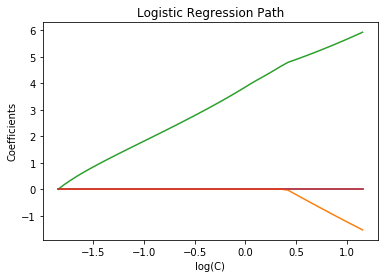

In [20]:
print("Computing regularization path ...")
start = datetime.now()
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
# 计算运行时间
print("This took ", datetime.now() - start)
coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()